In [925]:
import pandas as pd
import numpy as np
import seaborn as  sns
import matplotlib.pyplot as plt
from summarytools import dfSummary
from functools import reduce
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE
from pycaret.classification import *
import warnings
warnings.filterwarnings('ignore',  category=UserWarning)


In [926]:
# read in data sets to variables
# load locally
try: 
    contract = pd.read_csv('/Users/mm/Documents/TripleTen/Sprints/Sprint17_FinalProject/TT-final-project/final_provider/contract.csv')
    internet = pd.read_csv('/Users/mm/Documents/TripleTen/Sprints/Sprint17_FinalProject/TT-final-project/final_provider/internet.csv')
    personal = pd.read_csv('/Users/mm/Documents/TripleTen/Sprints/Sprint17_FinalProject/TT-final-project/final_provider/personal.csv')
    phone = pd.read_csv('/Users/mm/Documents/TripleTen/Sprints/Sprint17_FinalProject/TT-final-project/final_provider/phone.csv')
    
# load on TripleTen platform
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [927]:
def check_df(df):
    
    print(df.info())
    print()
    print(df.head())
    print()

In [928]:
dfs = [('Contract', contract),('Internet', internet), ('Personal', personal), ('Phone', phone)
]

for name, df in dfs:
    
    print(f'{name}')
    print()
    check_df(df)
    print()
    print(f"{'-' * 70}")
    print()


Contract

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-0

In [929]:
# merge all 4 dataframes into one dataset on 'customerID' one-by-one using a list
df_list = [contract, internet, personal, phone]

master_df = reduce(lambda left, right: pd.merge(left, right, on='customerID', how='outer'), df_list)

check_df(master_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [930]:
# fill all missing values left from merged data sets with 'No' to signify that it does not apply to the customer
df_full = master_df.fillna('No')

check_df(df_full)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [931]:
#  get a report of the dataset
dfSummary(df_full)

We can see from the dataframe summary that we now have no missing values, no duplicate rows, and an overview of the distributions in each column.  The dataframe has 7043 rows and 20 columns, 18 of which are of data type 'object'.  We'll change the BeginDate and dated EndDate entries to the datetime data type, and the TotalCharges column to float64.  We can see that 73.5% of the recorded customerID's remain clients (have no EndDate), while the remaining 26.5% of former customers left between October 2019 and January 2020.

In [932]:
# add binary column for customers whov've churned
df_full['Churn'] = df_full['EndDate'].apply(lambda x: 0 if x == 'No' else  1)

df_full['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [933]:
# change BeginDate to datetime data type
df_full['BeginDate'] = pd.to_datetime(df_full['BeginDate'])

# change EndDate 'No' to last recorded date and shift values to datetime data type
df_full['EndDate'] = df_full['EndDate'].replace(to_replace='No', value='2020-02-01 00:00:00')
df_full['EndDate'] = pd.to_datetime(df_full['EndDate'])
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   InternetService   7043 non-null   object        
 9   OnlineSecurity    7043 non-null   object        
 10  OnlineBackup      7043 non-null   object        
 11  DeviceProtection  7043 non-null   object        
 12  TechSupport       7043 non-null   object        
 13  StreamingTV       7043 non-null   object        
 14  StreamingMovies   7043 n

In [934]:
df_full[df_full['TotalCharges'] == ' ']


customerID  BeginDate    EndDate      Type PaperlessBilling  \
488   4472-LVYGI 2020-02-01 2020-02-01  Two year              Yes   
753   3115-CZMZD 2020-02-01 2020-02-01  Two year               No   
936   5709-LVOEQ 2020-02-01 2020-02-01  Two year               No   
1082  4367-NUYAO 2020-02-01 2020-02-01  Two year               No   
1340  1371-DWPAZ 2020-02-01 2020-02-01  Two year               No   
3331  7644-OMVMY 2020-02-01 2020-02-01  Two year               No   
3826  3213-VVOLG 2020-02-01 2020-02-01  Two year               No   
4380  2520-SGTTA 2020-02-01 2020-02-01  Two year               No   
5218  2923-ARZLG 2020-02-01 2020-02-01  One year              Yes   
6670  4075-WKNIU 2020-02-01 2020-02-01  Two year               No   
6754  2775-SEFEE 2020-02-01 2020-02-01  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges InternetService  \
488   Bank transfer (automatic)           52.55                          DSL   
753                Mailed check           20.25                           No   
936                Mailed check           80.85                          DSL   
1082               Mailed check           25.75                           No   
1340    Credit card (automatic)           56.05                          DSL   
3331               Mailed check           19.85                           No   
3826               Mailed check           25.35                           No   
4380               Mailed check           20.00                           No   
5218               Mailed check           19.70                           No   
6670               Mailed check           73.35                          DSL   
6754  Bank transfer (automatic)           61.90                          DSL   

     OnlineSecurity  ... DeviceProtection TechSupport StreamingTV  \
488             Yes  ...              Yes         Yes         Yes   
753              No  ...               No          No          No   
936             Yes  ...              Yes          No         Yes   
1082             No  ...               No          No          No   
1340            Yes  ...              Yes         Yes         Yes   
3331             No  ...               No          No          No   
3826             No  ...               No          No          No   
4380             No  ...               No          No          No   
5218             No  ...               No          No          No   
6670             No  ...              Yes         Yes         Yes   
6754            Yes  ...               No         Yes          No   

     StreamingMovies  gender SeniorCitizen  Partner Dependents MultipleLines  \
488               No  Female             0      Yes        Yes            No   
753               No    Male             0       No        Yes            No   
936              Yes  Female             0      Yes        Yes            No   
1082              No    Male             0      Yes        Yes           Yes   
1340              No  Female             0      Yes        Yes            No   
3331              No    Male             0      Yes        Yes            No   
3826              No    Male             0      Yes        Yes           Yes   
4380              No  Female             0      Yes        Yes            No   
5218              No    Male             0      Yes        Yes            No   
6670              No  Female             0      Yes        Yes           Yes   
6754              No    Male             0       No        Yes           Yes   

     Churn  
488      0  
753      0  
936      0  
1082     0  
1340     0  
3331     0  
3826     0  
4380     0  
5218     0  
6670     0  
6754     0  

[11 rows x 21 columns]

The 11 customers who have an empty cell in the TotalCharges column seem to be brand new customers. Since they are only a small portion of the data set(less than 0.5%), and won't give us any insight into customer churn, we'll drop these rows from the dataframe.

In [935]:
# change the data types to numeric for all other entries leaving the empty cells as null
df_full['TotalCharges'] = pd.to_numeric(df_full['TotalCharges'], errors='coerce')
# drop the null entries
df_full.dropna(how='any', inplace=True)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   InternetService   7032 non-null   object        
 9   OnlineSecurity    7032 non-null   object        
 10  OnlineBackup      7032 non-null   object        
 11  DeviceProtection  7032 non-null   object        
 12  TechSupport       7032 non-null   object        
 13  StreamingTV       7032 non-null   object        
 14  StreamingMovies   7032 non-nu

### Primary Questions

* What are the features of most importance in predicting whether a customer will leave or not?
* What is the most accurate predictive model for this binary classification problem?

### 

### Project Plan

1. Load the data locally, or from the platform

2. Perform a preliminary overview of the data sets
    * Look into what kind of data is available
    * Are there missing values?
    * Any dupilcate entries?
    * Make sure all features contain the appropriate data types

3. Preprocess the data
    * Fill in or remove missing values
    * Add any additional intuitive features
    * Consolidate separate dataframes into one based on the common CustomerID column

4. In depth EDA with data visualizations
    * Explore the relationship, or lack thereof, between customer churn and each of the features
    * Determine feature importances

5. Feature Engineering   
    * One hot encode categorical features
    * Standardize binary and numerical features

6. Train and test predictive model
    * Determine the best binary classification predictive model based on AUC-ROC and Accuracy scores
    * Train the model on the cleaned, extracted data
    * Achieve an AUC-ROC > 0.81

7. Conclusions
    * Highlight findings
    * Offer potential actionable insights based on results

### EDA

#### Feature engineering

To better train our model lets add some features from the existing ones that might help fill out some of the ML algorithms

* Add tenure features for both tenure months and tenure years utilizing the begin and end dates
* Add an extra services feature to show how many extra services a customer subscribes to, if any

In [936]:

# calculate subscription tenure (in months and years) for remaining customers and create new tenure feature
df_full['TenureMonths'] = round((df_full['EndDate']  -  df_full['BeginDate']) / np.timedelta64(31, 'D'))
df_full['TenureYears'] = round(df_full['TenureMonths'] / 12, 2)

df_full.sample(5)

customerID  BeginDate    EndDate            Type PaperlessBilling  \
3281  6322-PJJDJ 2016-01-01 2020-02-01        Two year              Yes   
1625  1262-OPMFY 2019-02-01 2019-11-01  Month-to-month              Yes   
4606  1734-ZMNTZ 2019-03-01 2020-02-01        Two year               No   
5443  7109-MFBYV 2017-12-01 2020-02-01  Month-to-month               No   
2762  8929-KSWIH 2018-01-01 2020-02-01        Two year               No   

                  PaymentMethod  MonthlyCharges  TotalCharges InternetService  \
3281           Electronic check           94.80       4690.65     Fiber optic   
1625  Bank transfer (automatic)           75.75        655.90     Fiber optic   
4606               Mailed check           25.00        300.70              No   
5443           Electronic check           45.45       1233.15             DSL   
2762  Bank transfer (automatic)           99.30       2513.50     Fiber optic   

     OnlineSecurity  ... StreamingTV StreamingMovies  gender SeniorCitizen  \
3281             No  ...         Yes             Yes    Male             0   
1625             No  ...          No              No  Female             0   
4606             No  ...          No              No  Female             0   
5443             No  ...          No              No    Male             0   
2762             No  ...         Yes             Yes    Male             0   

     Partner Dependents  MultipleLines Churn TenureMonths TenureYears  
3281     Yes         No             No     0         48.0        4.00  
1625     Yes         No             No     1          9.0        0.75  
4606     Yes        Yes            Yes     0         11.0        0.92  
5443      No         No             No     0         26.0        2.17  
2762      No         No             No     0         25.0        2.08  

[5 rows x 23 columns]

In [937]:
# add new featue for sum of subscription services
df_full['ExtraServicesSum'] = [row.count('Yes') for row in zip(df_full['OnlineSecurity'], df_full['OnlineBackup'], df_full['DeviceProtection'], df_full['TechSupport'], df_full['StreamingTV'], df_full['StreamingMovies'])]

df_full.sample(5)

customerID  BeginDate    EndDate            Type PaperlessBilling  \
1510  7898-PDWQE 2014-03-01 2020-02-01        Two year               No   
2493  8622-ZLFKO 2019-08-01 2020-02-01  Month-to-month              Yes   
5165  8062-YBDOE 2019-09-01 2019-10-01  Month-to-month              Yes   
3648  9419-IPPBE 2015-11-01 2020-02-01        One year              Yes   
4872  8125-QPFJD 2014-02-01 2020-02-01        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges InternetService  \
1510    Credit card (automatic)           80.40       5727.15             DSL   
2493           Electronic check           90.75        512.25     Fiber optic   
5165           Electronic check           69.65         69.65     Fiber optic   
3648           Electronic check           90.15       4554.85     Fiber optic   
4872  Bank transfer (automatic)           84.90       6065.30             DSL   

     OnlineSecurity  ... StreamingMovies  gender SeniorCitizen Partner  \
1510            Yes  ...             Yes    Male             0     Yes   
2493             No  ...             Yes  Female             0     Yes   
5165             No  ...              No    Male             1      No   
3648             No  ...             Yes  Female             0     Yes   
4872            Yes  ...             Yes  Female             0     Yes   

     Dependents MultipleLines  Churn TenureMonths TenureYears ExtraServicesSum  
1510         No           Yes      0         70.0        5.83                5  
2493         No           Yes      0          6.0        0.50                2  
5165         No            No      1          1.0        0.08                0  
3648        Yes           Yes      0         50.0        4.17                2  
4872         No           Yes      0         71.0        5.92                5  

[5 rows x 24 columns]

#### Overview of features

Let's take a look at our features by visualizing the feature distributions, and attempt identify any strong correllations with customer churn

In [938]:
from ydata_profiling import ProfileReport

ProfileReport(df_full)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [939]:
# function to compare categorical featrues to customer churn
def compare_churn(df, features, target):
    num_col = 2
    num_rows = math.ceil(len(features)/2)
    
    fig = plt.figure(figsize=(12, 5*num_rows))
    
    for index, column in enumerate(features, 1):
        ax = fig.add_subplot(num_rows, num_col, index)
        ax = sns.countplot(x=column, data=df, hue=target, palette='Blues')
        ax.set_title(column)
    return plt.show()

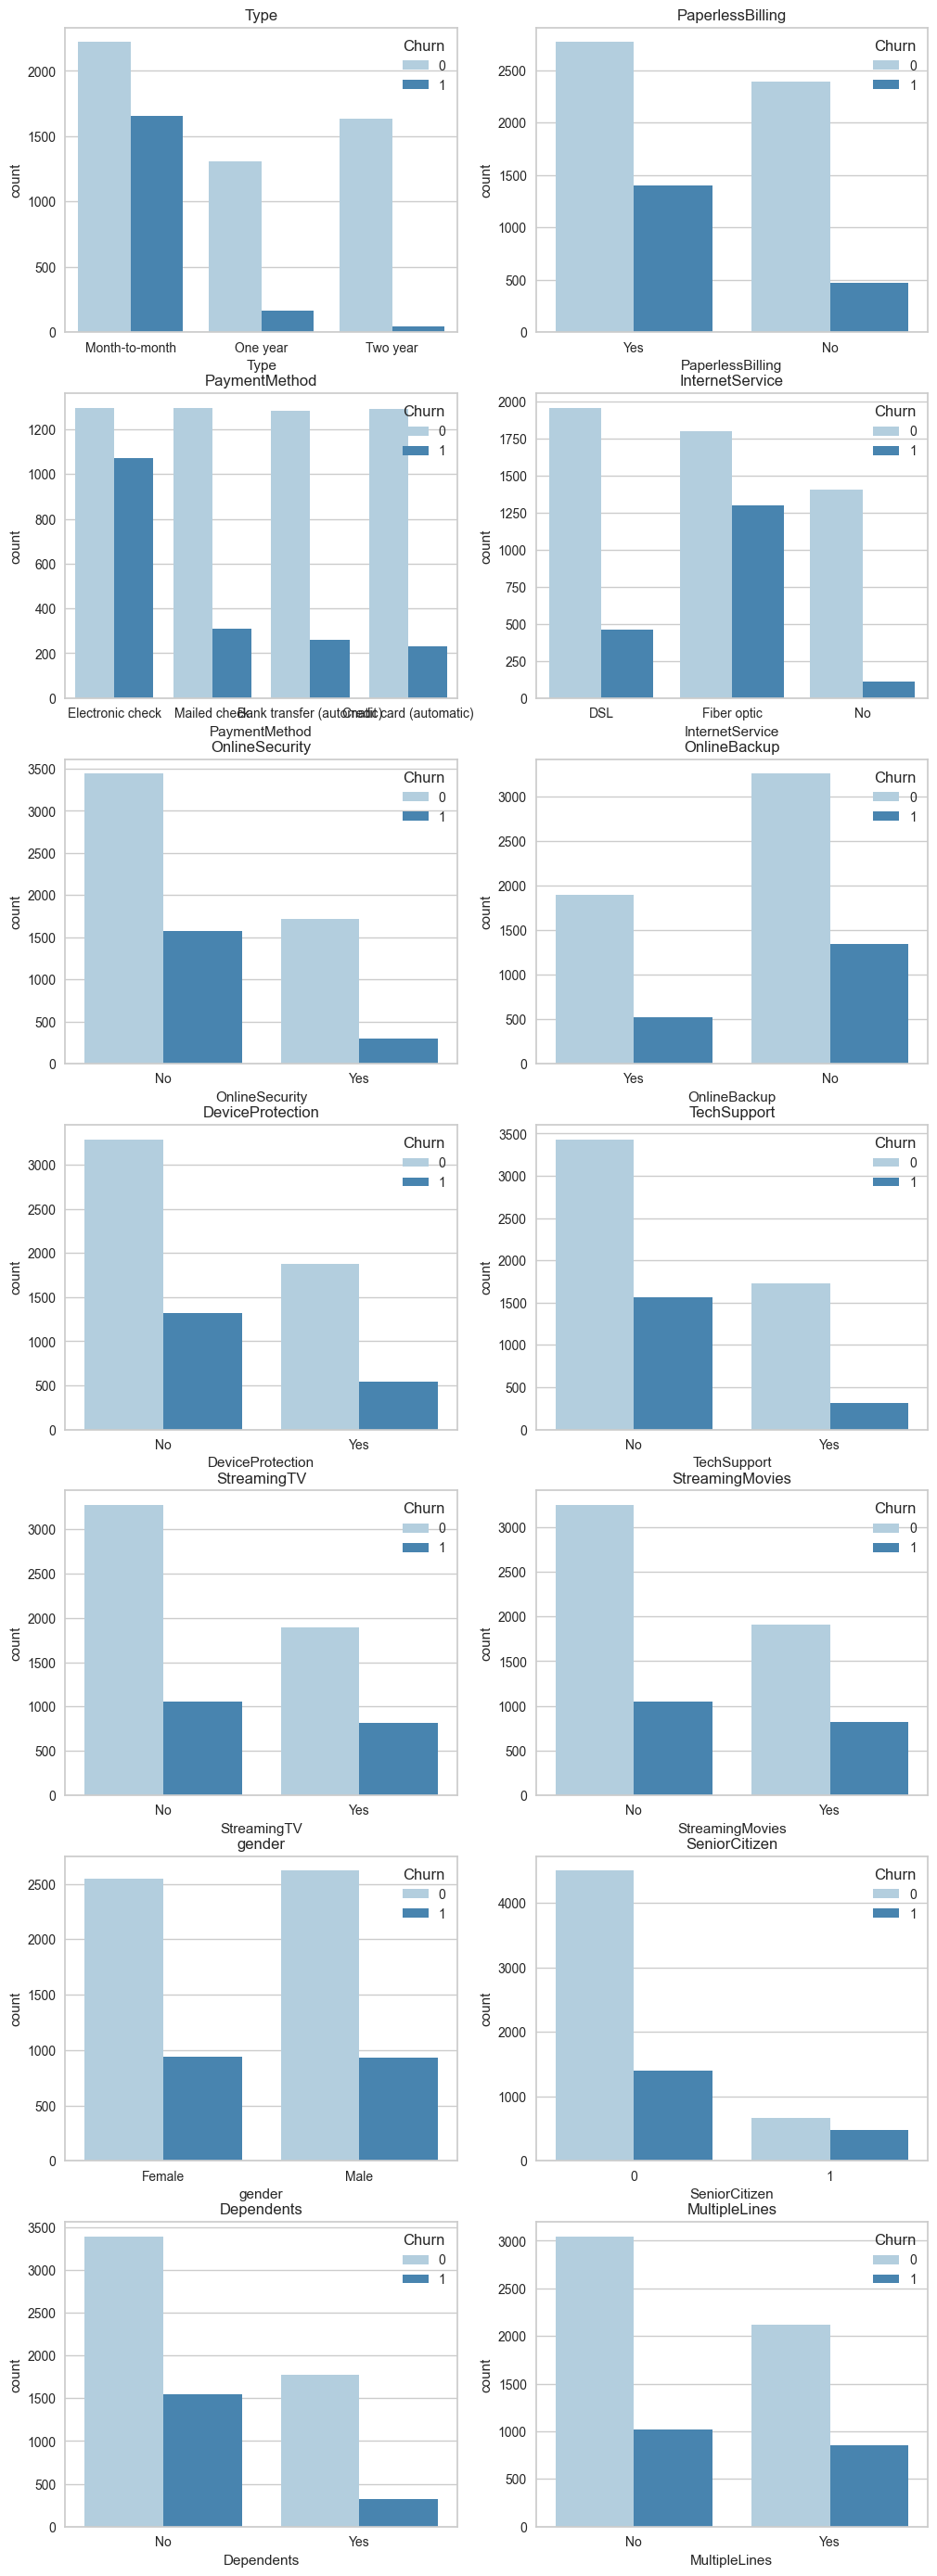

In [940]:
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Dependents', 'MultipleLines']

compare_churn(df_full, cat_features, 'Churn')

In [941]:
# function too compare numerical features with customer churn
def num_churn(df, num_features, target):
    columns  = 2
    rows = math.ceil(len(num_features)/2)
    fig = plt.figure(figsize=(12, 5 * rows))
    
    for index, column in enumerate(num_features, 1):
        ax = fig.add_subplot(rows, columns, index)
        ax = sns.kdeplot(x = df[column], hue = df[target], fill=True)
        ax.set_title(column)
        ax.legend(['Churn', 'No Churn'], loc='upper right')
    return plt.show()

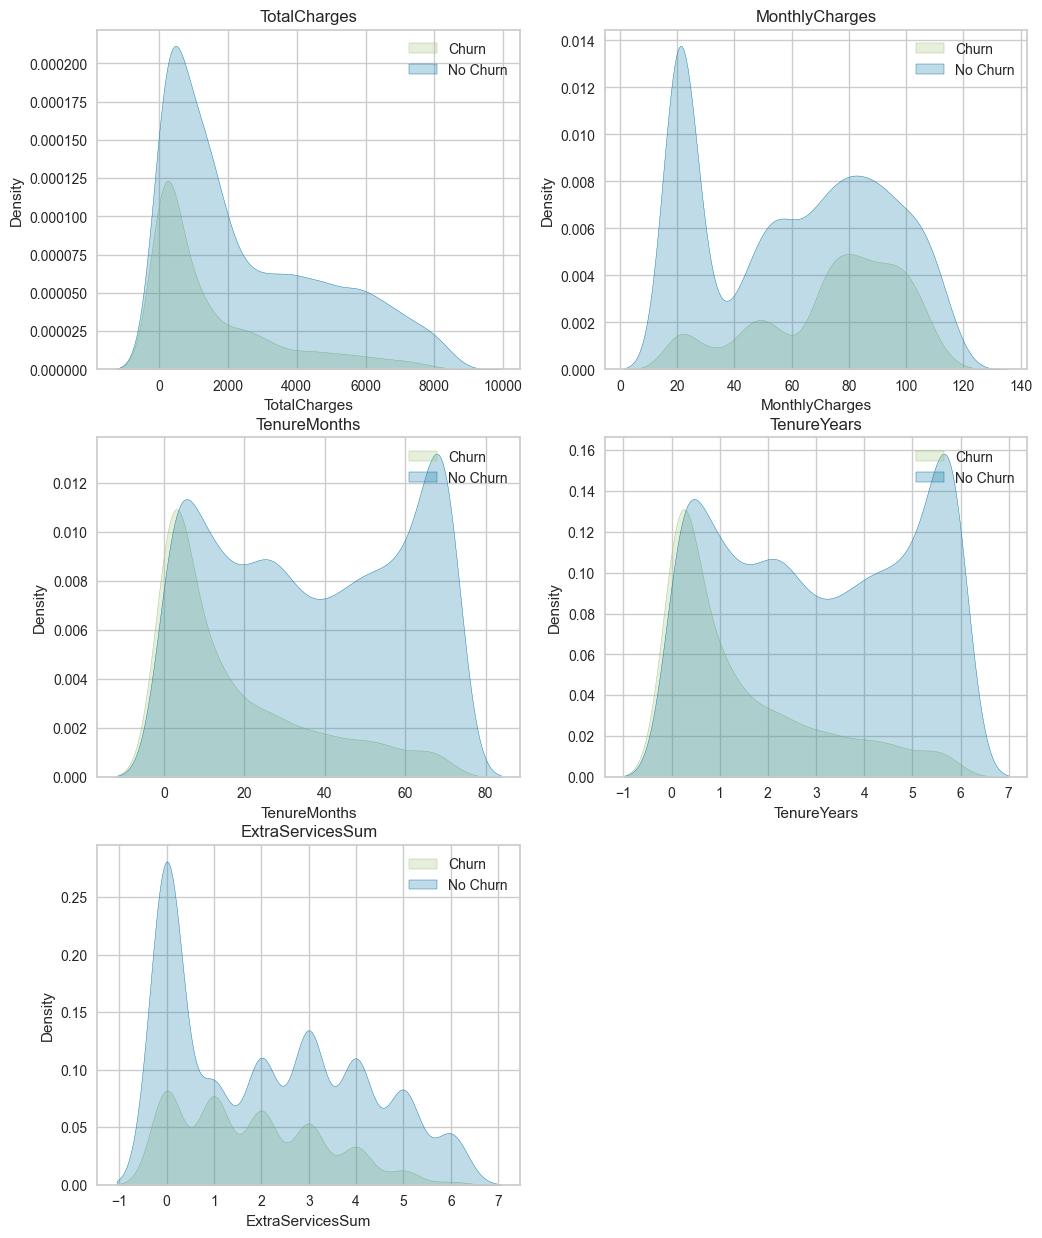

In [942]:
num_features = ['TotalCharges', 'MonthlyCharges', 'TenureMonths', 'TenureYears', 'ExtraServicesSum']
num_churn(df_full, num_features, 'Churn')

It can be inferred and verified above that extra services beyond the main landline and internet services have a high correllation with both MonthlyCharges and TotalCharges. Likewise, the longer a customer has been with the company (Tenure), has a high correllation to TotalCharges, as well as a lower likelyhood of churning. Also, we can see that of the customers whove churned, the majority tended to have higher monthly costs. Most importantly, we see from the above analysis that subscription type (Type) is highly correllated with Tenure.  We can also see that month-to-month subscribers, and those who pay by electronic check tend to churn more than other customers.  Those with fiber optic internet service also seem to have a lopsided trend to churning.  However, somewhat counter intuitively, churn rate seems to decrease as the number of subsciption services increases.

Moving forward for model training:

* We will ignore the customerID as it has all unique values and tells us nothing about Churn 
* Begin and End Dates will also be ignored since we've already added the numeric Tenure in months and years to the dataset  
* Form a One Hot Encoded set of the data for possible regression modeling
* Form an Ordinal Encoded set of the data for better performance in tree based models
* Split off 5% of the data so it's unseen in model training, to be introduced to the final model after testing to mimic a real world scenario
* Scale the numerical features to normalize the range of values
* Fix target imbalance using by upsampling

### Data prep for ML models

In [943]:
# drop unnecessary features
drop_features = ['BeginDate', 'EndDate', 'customerID']
df = df_full.drop(drop_features, axis=1)
df.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'Churn', 'TenureMonths', 'TenureYears', 'ExtraServicesSum'],
      dtype='object')

#### One Hot Encode dataset

In [944]:
df_ohe = pd.get_dummies(df, drop_first=True, dtype=int)

df_ohe.sample(10)

MonthlyCharges  TotalCharges  SeniorCitizen  Churn  TenureMonths  \
4072           79.55        718.55              1      0           9.0   
3410           53.40        188.70              0      1           3.0   
2292           91.30       4965.00              0      0          53.0   
4850          100.05       5299.65              0      0          53.0   
4744           20.05       1198.05              1      0          63.0   
655            95.10        865.10              0      0          10.0   
59            107.50       7853.70              0      0          71.0   
5537          115.05       8016.60              1      0          70.0   
6922           74.45        221.10              0      0           3.0   
4824           97.25       7133.10              1      0          71.0   

      TenureYears  ExtraServicesSum  Type_One year  Type_Two year  \
4072         0.75                 1              0              0   
3410         0.25                 1              0              0   
2292         4.42                 6              0              1   
4850         4.42                 4              1              0   
4744         5.25                 0              0              1   
655          0.83                 3              0              0   
59           5.92                 4              0              1   
5537         5.83                 6              0              1   
6922         0.25                 1              0              0   
4824         5.92                 3              1              0   

      PaperlessBilling_Yes  ...  OnlineSecurity_Yes  OnlineBackup_Yes  \
4072                     1  ...                   0                 0   
3410                     0  ...                   0                 0   
2292                     0  ...                   1                 1   
4850                     1  ...                   1                 1   
4744                     1  ...                   0                 0   
655                      1  ...                   0                 0   
59                       1  ...                   0                 0   
5537                     1  ...                   1                 1   
6922                     0  ...                   0                 1   
4824                     1  ...                   0                 1   

      DeviceProtection_Yes  TechSupport_Yes  StreamingTV_Yes  \
4072                     0                0                0   
3410                     0                0                1   
2292                     1                1                1   
4850                     0                0                1   
4744                     0                0                0   
655                      0                1                1   
59                       1                1                1   
5537                     1                1                1   
6922                     0                0                0   
4824                     0                0                1   

      StreamingMovies_Yes  gender_Male  Partner_Yes  Dependents_Yes  \
4072                    1            1            0               0   
3410                    0            1            0               0   
2292                    1            0            1               1   
4850                    1            0            0               0   
4744                    0            1            0               0   
655                     1            1            0               0   
59                      1            0            0               0   
5537                    1            1            1               0   
6922                    0            1            0               0   
4824                    1            1            1               0   

      MultipleLines_Yes  
4072                  0  
3410                  0  
2292                  1  
4850                  0  
4744      

In [945]:
# split features from target
target_ohe = df_ohe['Churn']
features_ohe = df_ohe.drop(['Churn'], axis=1)

In [946]:
# Split the training and hold 5% of data unseen by pycaret
features_ohe_train, features_ohe_unseen, target_ohe_train, target_ohe_unseen =  train_test_split(features_ohe, target_ohe, test_size=0.05, random_state=12345)
features_ohe_train.shape

(6680, 24)

In [947]:
target_ohe_train.shape

(6680,)

#### Ordinal Encoded dataset

In [948]:
encoder = OrdinalEncoder()
df_ord = pd.DataFrame(encoder.fit_transform(df), columns=df.columns)
df_ord.sample(10)

Type  PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  \
1016   0.0               1.0            3.0            19.0        1540.0   
481    0.0               1.0            0.0           311.0        3809.0   
1302   1.0               0.0            1.0          1550.0        6475.0   
5868   1.0               1.0            1.0          1413.0        5743.0   
6267   1.0               0.0            1.0            36.0        1240.0   
4523   0.0               1.0            0.0           886.0        1899.0   
2370   2.0               1.0            0.0          1462.0        6431.0   
4018   0.0               1.0            0.0           802.0        1199.0   
5348   2.0               0.0            3.0            28.0        2848.0   
6221   0.0               0.0            3.0            30.0          23.0   

      InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
1016              2.0             0.0           0.0               0.0   
481               0.0             1.0           0.0               1.0   
1302              1.0             1.0           1.0               1.0   
5868              1.0             1.0           0.0               1.0   
6267              2.0             0.0           0.0               0.0   
4523              1.0             0.0           0.0               1.0   
2370              1.0             1.0           1.0               1.0   
4018              1.0             0.0           0.0               1.0   
5348              2.0             0.0           0.0               0.0   
6221              2.0             0.0           0.0               0.0   

      TechSupport  ...  StreamingMovies  gender  SeniorCitizen  Partner  \
1016          0.0  ...              0.0     0.0            0.0      0.0   
481           0.0  ...              1.0     0.0            0.0      1.0   
1302          1.0  ...              1.0     0.0            0.0      0.0   
5868          0.0  ...              1.0     0.0            0.0      0.0   
6267          0.0  ...              0.0     0.0            0.0      1.0   
4523          0.0  ...              0.0     1.0            0.0      1.0   
2370          1.0  ...              1.0     0.0            1.0      1.0   
4018          0.0  ...              0.0     1.0            0.0      0.0   
5348          0.0  ...              0.0     1.0            0.0      1.0   
6221          0.0  ...              0.0     0.0            0.0      1.0   

      Dependents  MultipleLines  Churn  TenureMonths  TenureYears  \
1016         0.0            0.0    0.0          22.0         22.0   
481          0.0            0.0    1.0          46.0         46.0   
1302         0.0            1.0    1.0          68.0         68.0   
5868         0.0            1.0    1.0          51.0         51.0   
6267         1.0            0.0    0.0          14.0         14.0   
4523         1.0            1.0    1.0           8.0          8.0   
2370         0.0            0.0    0.0          69.0         69.0   
4018         0.0            0.0    1.0           3.0          3.0   
5348         0.0            0.0    0.0          58.0         58.0   
6221         1.0            0.0    0.0           0.0          0.0   

      ExtraServicesSum  
1016               0.0  
481                3.0  
1302               6.0  
5868               4.0  
6267               0.0  
4523               1.0  
2370               6.0  
4018               1.0  
5348               0.0  
6221               0.0  

[10 rows x 21 columns]

In [949]:
#split features from target
target_ord = df_ord['Churn']
features_ord = df_ord.drop(['Churn'], axis=1)

In [950]:
# Split training and hold 5% of ordinal encoded data unseen by pycaret
features_ord_train, features_ord_unseen, target_ord_train, target_ord_unseen = train_test_split(features_ord, target_ord, test_size=0.05, random_state=12345)
features_ord_train.shape

(6680, 20)

In [951]:
target_ord_train.shape

(6680,)

#### Feature scaling

In [952]:
scaler = StandardScaler()

In [953]:
# feature scale ohe set
scaler.fit(features_ohe_train[num_features])
features_ohe_train[num_features] = scaler.transform(features_ohe_train[num_features])
features_ohe_unseen[num_features] = scaler.transform(features_ohe_unseen[num_features])
features_ohe_train.sample(10)

MonthlyCharges  TotalCharges  SeniorCitizen  TenureMonths  TenureYears  \
6435       -0.485366      0.120106              0      0.791990     0.791878   
5827        0.837728      0.360115              0      0.044739     0.044805   
5025        0.165390     -0.841766              0     -1.076136    -1.075805   
869        -1.275571     -0.955184              0     -1.200678    -1.200317   
3672        0.177011      0.633562              0      0.875017     0.876546   
1745       -1.494703     -0.513775              0      0.958045     0.956234   
5554       -1.468142     -0.434744              0      1.248643     1.250083   
1085        0.314799     -0.593137              1     -0.785539    -0.786936   
2598        0.343020     -0.776724              0     -1.034622    -1.035961   
3718        1.156466      1.420951              0      0.999559     1.001059   

      ExtraServicesSum  Type_One year  Type_Two year  PaperlessBilling_Yes  \
6435          1.061977              0              1                     0   
5827         -0.020912              0              0                     1   
5025         -1.103801              0              0                     1   
869          -1.103801              0              1                     1   
3672         -0.020912              1              0                     1   
1745         -1.103801              0              1                     1   
5554         -1.103801              0              1                     1   
1085         -0.562356              0              0                     1   
2598         -0.562356              0              0                     1   
3718          0.520532              0              0                     1   

      PaymentMethod_Credit card (automatic)  ...  OnlineSecurity_Yes  \
6435                                      0  ...                   0   
5827                                      1  ...                   0   
5025                                      0  ...                   0   
869                                       0  ...                   0   
3672                                      1  ...                   0   
1745                                      1  ...                   0   
5554                                      0  ...                   0   
1085                                      0  ...                   0   
2598                                      0  ...                   0   
3718                                      0  ...                   1   

      OnlineBackup_Yes  DeviceProtection_Yes  TechSupport_Yes  \
6435                 1                     1                1   
5827                 0                     1                0   
5025                 0                     0                0   
869                  0                     0                0   
3672                 0                     0                0   
1745                 0                     0                0   
5554                 0                     0                0   
1085                 0                     1                0   
2598                 0                     1                0   
3718                 0                     0                0   

      StreamingTV_Yes  StreamingMovies_Yes  gender_Male  Partner_Yes  \
6435                1                    0            1            1   
5827                0                    1            1            1   
5025                0                    0            1            1   
869                 0                    0            1            0   
3672                1                    1            0            1   
1745                0                    0            0            1   
5554                0                    0            0            0   
1085                0                    0            0            0   
2598                0                    0            0            0   
3718                1                

In [954]:
#feature scale ordinal encoded set
scaler.fit(features_ord_train[num_features])
features_ord_train[num_features] = scaler.transform(features_ord_train[num_features])
features_ord_unseen[num_features] = scaler.transform(features_ord_unseen[num_features])
features_ord_train.sample(10)

Type  PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  \
6765   2.0               1.0            1.0        0.447313      1.131221   
1484   1.0               1.0            3.0       -0.374034     -0.107676   
5928   0.0               1.0            2.0        0.606149     -0.658067   
917    1.0               1.0            3.0        1.423316      0.402003   
6246   1.0               1.0            3.0        1.659479      1.681097   
6966   0.0               1.0            3.0       -0.656176     -0.160756   
3738   1.0               0.0            0.0        0.275938      0.321094   
526    1.0               1.0            1.0        1.038767      1.270365   
6992   0.0               0.0            2.0       -1.003106     -0.313299   
5743   2.0               1.0            0.0       -1.195381      0.218540   

      InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
6765              0.0             1.0           0.0               1.0   
1484              0.0             1.0           1.0               0.0   
5928              1.0             0.0           0.0               0.0   
917               1.0             0.0           1.0               1.0   
6246              1.0             1.0           0.0               1.0   
6966              0.0             0.0           1.0               0.0   
3738              1.0             0.0           1.0               0.0   
526               1.0             0.0           1.0               0.0   
6992              0.0             0.0           0.0               1.0   
5743              2.0             0.0           0.0               0.0   

      TechSupport  StreamingTV  StreamingMovies  gender  SeniorCitizen  \
6765          1.0          1.0              1.0     0.0            1.0   
1484          1.0          0.0              0.0     0.0            0.0   
5928          0.0          0.0              1.0     0.0            1.0   
917           1.0          1.0              1.0     0.0            0.0   
6246          1.0          1.0              1.0     1.0            1.0   
6966          0.0          0.0              0.0     1.0            0.0   
3738          0.0          0.0              0.0     1.0            0.0   
526           1.0          1.0              0.0     1.0            0.0   
6992          1.0          0.0              0.0     1.0            0.0   
5743          0.0          0.0              0.0     1.0            0.0   

      Partner  Dependents  MultipleLines  TenureMonths  TenureYears  \
6765      1.0         0.0            0.0      1.207129     1.207129   
1484      1.0         1.0            0.0     -0.370400    -0.370400   
5928      1.0         0.0            1.0     -0.993108    -0.993108   
917       0.0         0.0            0.0     -0.453428    -0.453428   
6246      1.0         0.0            1.0      1.497726     1.497726   
6966      0.0         0.0            0.0     -0.328886    -0.328886   
3738      0.0         0.0            0.0     -0.245858    -0.245858   
526       1.0         1.0            1.0      1.041073     1.041073   
6992      0.0         0.0            0.0     -0.245858    -0.245858   
5743      1.0         1.0            1.0      1.497726     1.497726   

      ExtraServicesSum  
6765          1.603421  
1484          0.520532  
5928         -0.562356  
917           1.603421  
6246          1.603421  
6966         -0.562356  
3738         -0.562356  
526           0.520532  
6992         -0.020912  
5743         -1.103801

#### Upscaling to fix target class imbalance

In [955]:
smote = SMOTE(random_state=12345)

In [956]:
ohe_feat_train_upsampled, ohe_target_train_upsampled = smote.fit_resample(features_ohe_train, target_ohe_train)
ohe_feat_train_upsampled.shape

(9826, 24)

In [957]:
# merge ohe features and target back together for setup
ohe_train = pd.merge(ohe_feat_train_upsampled, ohe_target_train_upsampled, how='left', left_index=True, right_index=True)
ohe_train.sample(10)

MonthlyCharges  TotalCharges  SeniorCitizen  TenureMonths  TenureYears  \
3624       -0.330978     -0.603834              0     -0.660997    -0.662424   
638        -0.302756      0.393088              0      0.999559     1.001059   
2081       -1.474782     -0.961218              0     -1.076136    -1.075805   
5205        1.131565      0.278034              1     -0.079802    -0.079707   
4196        0.689980     -0.182934              0     -0.370400    -0.368575   
1699        0.670059      0.151156              0     -0.121316    -0.119551   
5310       -1.346955     -0.246693              0      1.539240     1.538951   
3190        0.167050     -0.920443              0     -1.200678    -1.200317   
5087        1.367298      0.994526              0      0.418364     0.418342   
4532        1.188008      1.471627              0      0.999559     1.001059   

      ExtraServicesSum  Type_One year  Type_Two year  PaperlessBilling_Yes  \
3624          1.603421              0              1                     0   
638          -0.020912              0              0                     0   
2081         -1.103801              0              1                     1   
5205          1.061977              0              0                     1   
4196         -0.562356              0              0                     0   
1699         -0.562356              0              0                     1   
5310         -1.103801              0              1                     0   
3190         -1.103801              0              0                     1   
5087          1.603421              1              0                     1   
4532          0.520532              0              0                     1   

      PaymentMethod_Credit card (automatic)  ...  OnlineBackup_Yes  \
3624                                      0  ...                 1   
638                                       0  ...                 0   
2081                                      1  ...                 0   
5205                                      0  ...                 0   
4196                                      0  ...                 0   
1699                                      0  ...                 0   
5310                                      0  ...                 0   
3190                                      0  ...                 0   
5087                                      1  ...                 1   
4532                                      0  ...                 1   

      DeviceProtection_Yes  TechSupport_Yes  StreamingTV_Yes  \
3624                     1                1                1   
638                      0                1                0   
2081                     0                0                0   
5205                     1                1                1   
4196                     0                0                0   
1699                     0                0                0   
5310                     0                0                0   
3190                     0                0                0   
5087                     0                1                1   
4532                     0                0                1   

      StreamingMovies_Yes  gender_Male  Partner_Yes  Dependents_Yes  \
3624                    0            1            0               0   
638                     0            1            1               0   
2081                    0            1            1               1   
5205                    1            0            1               1   
4196                    1            0            1               1   
1699                    1            0            1               0   
5310                    0            1            1               0   
3190                    0            0            0               0   
5087                    1            0            0               1   
4532                    1            0            1               1   

      Mu

In [958]:
# Upsample ordinal encoded set
ord_feat_train_upsampled, ord_target_train_upsampled = smote.fit_resample(features_ord_train, target_ord_train)
ord_feat_train_upsampled.shape


(9826, 20)

In [959]:
# Merge ordinal encoded features and target back together for setup
ord_train = pd.merge(ord_feat_train_upsampled, ord_target_train_upsampled, how='left', left_index=True, right_index=True)
ord_train.sample(10)

Type  PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  \
1170   0.0          1.000000       2.000000        0.491202     -0.954392   
4118   0.0          1.000000       2.000000        0.804693      0.106709   
5244   1.0          1.000000       2.000000       -0.881890     -0.804426   
5535   0.0          1.000000       0.000000       -0.806652     -0.980159   
8144   1.0          1.000000       2.000000        0.676976      0.656152   
3708   2.0          0.000000       1.000000       -0.543319      0.422617   
3349   2.0          0.000000       1.000000       -1.398105     -0.180340   
7043   0.0          1.000000       2.553563        0.722254      0.375484   
9361   0.0          0.315797       2.000000        1.139852      0.431022   
4316   0.0          1.000000       2.000000        0.802603      0.743164   

      InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
1170              1.0             0.0           0.0               0.0   
4118              1.0             0.0           0.0               0.0   
5244              0.0             0.0           0.0               1.0   
5535              0.0             0.0           0.0               0.0   
8144              1.0             0.0           0.0               1.0   
3708              0.0             1.0           0.0               1.0   
3349              2.0             0.0           0.0               0.0   
7043              1.0             0.0           1.0               0.0   
9361              1.0             0.0           0.0               0.0   
4316              1.0             0.0           1.0               0.0   

      TechSupport  ...  StreamingMovies  gender  SeniorCitizen   Partner  \
1170          0.0  ...         0.000000     1.0            0.0  0.000000   
4118          1.0  ...         0.000000     0.0            0.0  1.000000   
5244          0.0  ...         0.000000     1.0            0.0  0.000000   
5535          0.0  ...         0.000000     1.0            0.0  0.000000   
8144          0.0  ...         0.052862     1.0            0.0  0.052862   
3708          0.0  ...         0.000000     1.0            0.0  1.000000   
3349          0.0  ...         0.000000     1.0            0.0  1.000000   
7043          0.0  ...         1.000000     0.0            0.0  0.000000   
9361          1.0  ...         1.000000     0.0            1.0  0.000000   
4316          0.0  ...         0.000000     0.0            0.0  1.000000   

      Dependents  MultipleLines  TenureMonths  TenureYears  ExtraServicesSum  \
1170    0.000000       0.000000     -1.159164    -1.159164         -0.562356   
4118    0.000000       1.000000     -0.577969    -0.577969         -0.020912   
5244    0.000000       0.000000     -0.868567    -0.868567         -0.020912   
5535    0.000000       0.000000     -1.034622    -1.034622         -1.103801   
8144    0.947138       0.000000      0.081864     0.081864          0.007710   
3708    0.000000       0.000000      0.501392     0.501392         -0.020912   
3349    1.000000       0.000000      1.082587     1.082587         -1.103801   
7043    0.000000       0.446437     -0.300714    -0.300714         -0.020912   
9361    0.000000       0.684203     -0.320150    -0.320150          0.520532   
4316    1.000000       1.000000      0.169281     0.169281         -0.020912   

      Churn  
1170    1.0  
4118    0.0  
5244    1.0  
5535    0.0  
8144    1.0  
3708    0.0  
3349    0.0  
7043    1.0  
9361    1.0  
4316    0.0  

[10 rows x 21 columns]

### Model Traning & Selection using pycaret

Pycaret splits the data into 70% training and 30% test sets internally, and analyzes the performance of multiple learning models based on the data given.  Using a python wrapper around several machine learning libraries, it allows comparison of multiple models to be executed quickly and efficiently, which is why I've employed it here after preprocessing outside of the pycaret library.

In [960]:
# Setup analysis for ohe dataset
setup_ohe = setup(ohe_train, target='Churn', index=False, session_id=12345, preprocess=False)

In [961]:
get_config()

{'USI',
 'X',
 'X_test',
 'X_test_transformed',
 'X_train',
 'X_train_transformed',
 'X_transformed',
 '_available_plots',
 '_ml_usecase',
 'data',
 'dataset',
 'dataset_transformed',
 'exp_id',
 'exp_name_log',
 'fix_imbalance',
 'fold_generator',
 'fold_groups_param',
 'fold_shuffle_param',
 'gpu_n_jobs_param',
 'gpu_param',
 'html_param',
 'idx',
 'is_multiclass',
 'log_plots_param',
 'logging_param',
 'memory',
 'n_jobs_param',
 'pipeline',
 'seed',
 'target_param',
 'test',
 'test_transformed',
 'train',
 'train_transformed',
 'variable_and_property_keys',
 'variables',
 'y',
 'y_test',
 'y_test_transformed',
 'y_train',
 'y_train_transformed',
 'y_transformed'}

In [962]:
# check transformed and encoded ohe dataset
get_config('X_train_transformed')

MonthlyCharges  TotalCharges  SeniorCitizen  TenureMonths  TenureYears  \
0          -0.506948     -0.986876              1     -1.283706    -1.284985   
1          -1.488063     -0.391737              1      1.456212     1.454283   
2           0.894172     -0.626089              0     -0.951594    -0.951292   
3           0.811806     -0.391762              0     -0.667520    -0.668306   
4           0.069105      0.922899              0      1.373184     1.374595   
...              ...           ...            ...           ...          ...   
6873       -1.498024     -0.444844              0      1.248643     1.250083   
6874       -0.511990     -0.926685              0     -1.159164    -1.160473   
6875        1.490145      2.484948              1      1.580754     1.578795   
6876        1.116315      0.528900              0      0.137719     0.139024   
6877        0.319779      0.636324              0      0.667448     0.667366   

      ExtraServicesSum  Type_One year  Type_Two year  PaperlessBilling_Yes  \
0            -0.562356              0              0                     1   
1            -1.103801              0              1                     1   
2             0.520532              0              0                     0   
3            -0.020912              0              0                     0   
4             0.520532              0              1                     0   
...                ...            ...            ...                   ...   
6873         -1.103801              0              1                     0   
6874         -0.562356              0              0                     0   
6875          2.144866              0              1                     1   
6876          0.650323              0              0                     1   
6877          1.061977              0              1                     1   

      PaymentMethod_Credit card (automatic)  ...  OnlineSecurity_Yes  \
0                                         0  ...                   1   
1                                         1  ...                   0   
2                                         0  ...                   1   
3                                         0  ...                   0   
4                                         0  ...                   1   
...                                     ...  ...                 ...   
6873                                      0  ...                   0   
6874                                      0  ...                   1   
6875                                      0  ...                   1   
6876                                      0  ...                   0   
6877                                      0  ...                   0   

      OnlineBackup_Yes  DeviceProtection_Yes  TechSupport_Yes  \
0                    0                     0                0   
1                    0                     0                0   
2                    1                     1                0   
3                    0                     0                0   
4                    1                     1                0   
...                ...                   ...              ...   
6873                 0                     0                0   
6874                 0                     0                0   
6875                 1                     1                1   
6876                 1                     1                0   
6877                 0                     1                1   

      StreamingTV_Yes  StreamingMovies_Yes  gender_Male  Partner_Yes  \
0                   0                    0            0            1   
1                   0                    0            1            0   
2                   0                    0            0            1   
3                   1                    1            0            0   
4                   0                    0            0            1   
...               ...         

In [963]:
#compare models on ohe data
best_ohe = compare_models(sort='AUC')

Initiated  . . . . . . . . . . . . . . . . . .             13:04:43
Status     . . . . . . . . . . . . . . . . . .     Fitting 10 Folds
Estimator  . . . . . . . . . . . . . . . . . .  Logistic Regression

In [964]:
#  Setup training and analysis for ordinal encoded dataset
setup_ord = setup(ord_train, target='Churn', index=False, session_id=12345, preprocess=False)

In [965]:
get_config()

{'USI',
 'X',
 'X_test',
 'X_test_transformed',
 'X_train',
 'X_train_transformed',
 'X_transformed',
 '_available_plots',
 '_ml_usecase',
 'data',
 'dataset',
 'dataset_transformed',
 'exp_id',
 'exp_name_log',
 'fix_imbalance',
 'fold_generator',
 'fold_groups_param',
 'fold_shuffle_param',
 'gpu_n_jobs_param',
 'gpu_param',
 'html_param',
 'idx',
 'is_multiclass',
 'log_plots_param',
 'logging_param',
 'memory',
 'n_jobs_param',
 'pipeline',
 'seed',
 'target_param',
 'test',
 'test_transformed',
 'train',
 'train_transformed',
 'variable_and_property_keys',
 'variables',
 'y',
 'y_test',
 'y_test_transformed',
 'y_train',
 'y_train_transformed',
 'y_transformed'}

In [966]:
get_config('X_train_transformed')

Type  PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  \
0      0.0          1.000000            2.0       -0.662446     -1.504784   
1      2.0          1.000000            1.0       -1.368846     -0.021097   
2      0.0          0.000000            0.0        0.925910     -0.434921   
3      0.0          0.000000            2.0        0.822217     -0.096694   
4      2.0          0.000000            0.0       -0.045913      1.021967   
...    ...               ...            ...             ...           ...   
6873   2.0          0.000000            3.0       -1.381385     -0.111283   
6874   0.0          0.962352            2.0       -0.668794     -1.186916   
6875   2.0          1.000000            0.0        1.626040      1.715625   
6876   0.0          1.000000            0.0        1.084147      0.740321   
6877   2.0          1.000000            0.0        0.232049      0.847264   

      InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
0                 0.0             1.0      0.000000               0.0   
1                 2.0             0.0      0.000000               0.0   
2                 1.0             1.0      1.000000               1.0   
3                 1.0             0.0      0.000000               0.0   
4                 0.0             1.0      1.000000               1.0   
...               ...             ...           ...               ...   
6873              2.0             0.0      0.000000               0.0   
6874              0.0             1.0      0.000000               0.0   
6875              1.0             1.0      1.000000               1.0   
6876              1.0             0.0      0.760288               1.0   
6877              0.0             0.0      0.000000               1.0   

      TechSupport  StreamingTV  StreamingMovies  gender  SeniorCitizen  \
0             0.0     0.000000         0.000000     0.0            1.0   
1             0.0     0.000000         0.000000     1.0            1.0   
2             0.0     0.000000         0.000000     0.0            0.0   
3             0.0     1.000000         1.000000     0.0            0.0   
4             0.0     0.000000         0.000000     0.0            0.0   
...           ...          ...              ...     ...            ...   
6873          0.0     0.000000         0.000000     1.0            0.0   
6874          0.0     0.000000         0.000000     1.0            0.0   
6875          1.0     1.000000         1.000000     0.0            1.0   
6876          0.0     0.760288         0.239712     0.0            0.0   
6877          1.0     1.000000         1.000000     0.0            0.0   

      Partner  Dependents  MultipleLines  TenureMonths  TenureYears  \
0         1.0         0.0            0.0     -1.283706    -1.283706   
1         0.0         0.0            0.0      1.456212     1.456212   
2         1.0         0.0            1.0     -0.951594    -0.951594   
3         0.0         0.0            0.0     -0.667520    -0.667520   
4         1.0         0.0            1.0      1.373184     1.373184   
...       ...         ...            ...           ...          ...   
6873      1.0         1.0            0.0      1.248643     1.248643   
6874      0.0         1.0            0.0     -1.159164    -1.159164   
6875      1.0         0.0            0.0      1.580754     1.580754   
6876      1.0         1.0            1.0      0.087962     0.087962   
6877      0.0         0.0            0.0      0.667448     0.667448   

      ExtraServicesSum  
0            -0.562356  
1            -1.103801  
2             0.520532  
3            -0.020912  
4             0.520532  
...                ...  
6873         -1.103801  
6874         -0.562356  
6875          2.144866  
6876          0.390741  
6877          1.061977  

[6878 rows x 20 columns]

In [967]:
best_ord = compare_models(sort='AUC')


Here we compared both of the encoded datasets among several classification models, including a dummy classifier. While the 2nd and 3rd best models differed between the one hot encoded set and the ordinal encoded set, both shared the best performing model, which is the Light Gradient Boosting Machine model.  The ordinal encoded set had a slightly better AUC and Accuracy score with a 0.93 and 0.84 respectively, compared to a 
0.91 and 0.83 for the one hot encoded set.  We'll move ahead with tuning and training the LightGBM model with the ordinal encoded data.

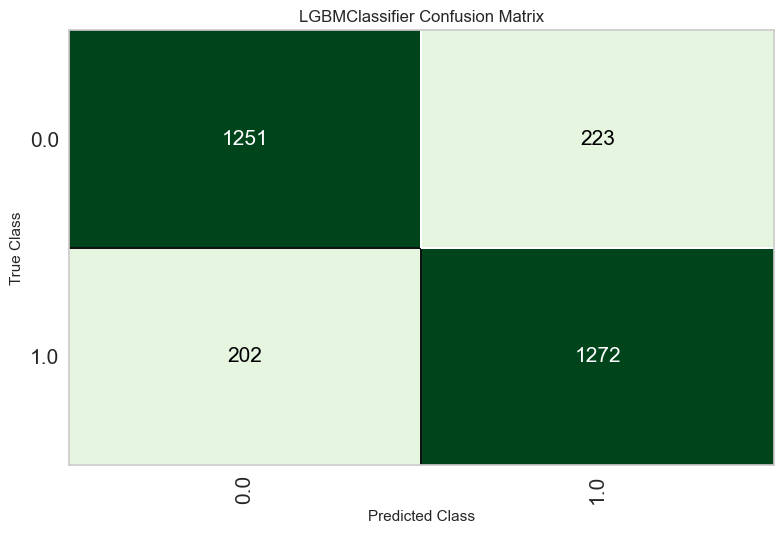

In [968]:
plot_model(best_ord, plot='confusion_matrix')

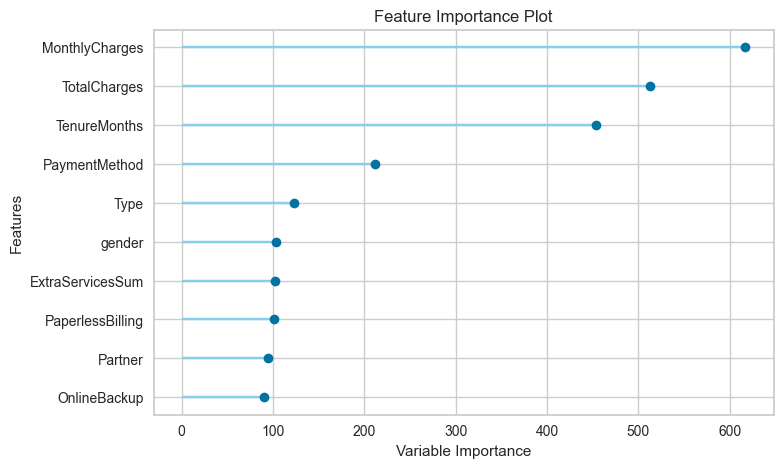

In [969]:
plot_model(best_ord, plot='feature')

### Create and tune best classifier model

#### LightGBM classifier

In [970]:
lightgbm =  create_model('lightgbm')


In [971]:
# Try tuning model hyperparameters, optimizing for AUC score
lightgbm_tuned, tuner = tune_model(lightgbm, optimize='AUC', return_tuner=True)


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Slightly better AUC than the base model, but slightly lower accuracy. Let's try bagging and boosting techniques next. Both encorporate an ensemble of homogeneous weak learners, combining the learning in separate ways.

In [972]:
# Try bagging our model
lightgbm_bagged = ensemble_model(lightgbm)


In [973]:
# Try double boosting
lightgbm_boost = ensemble_model(lightgbm, method='Boosting')

After tuning, the bagged LightGBM model shows the best performance with 0.93 AUC and 0.85 Accuracy scores. Lets use it as our final model to predict our test set.

In [974]:
type(lightgbm_bagged)
# >> sklearn.ensemble._bagging.BaggingClassifier
print(lightgbm_bagged)

BaggingClassifier(bootstrap=True, bootstrap_features=False,
                  estimator=LGBMClassifier(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=12345,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           subsample=1.0,
                                           subsample_for_bin=200000,
                                          

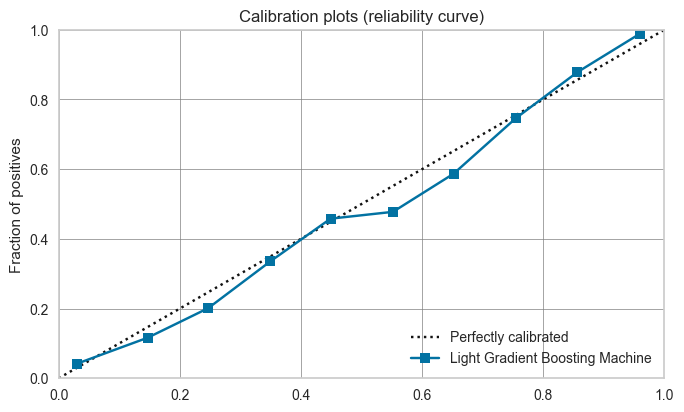

In [975]:
# plot model before calibration
plot_model(lightgbm_bagged, plot='calibration')

Looking at the calibration of our model, it appears that it tends to underestimate the probablities of positive outcomes more that overestimate.  It does however track diagonally, showing that the predicted probabilities mostly match the observed frequencies.  A fairly even distribution of true positives and true negatives in the confusion matrix below reflects this.

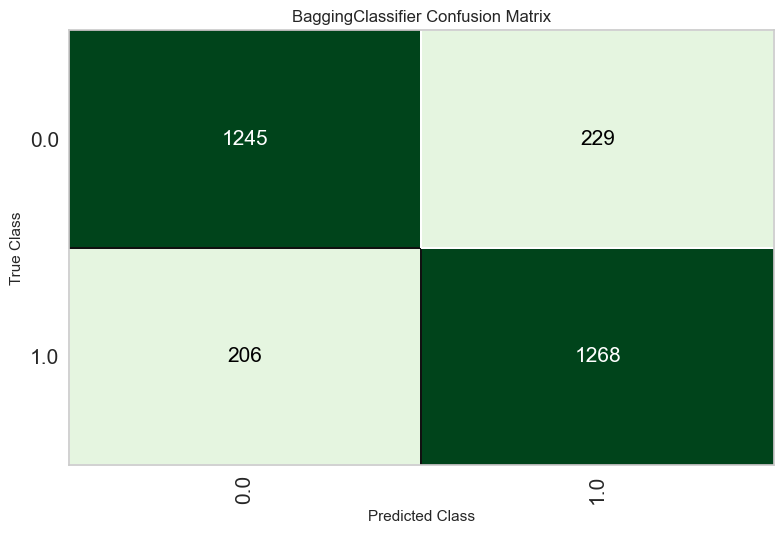

In [976]:
plot_model(lightgbm_bagged, plot='confusion_matrix')

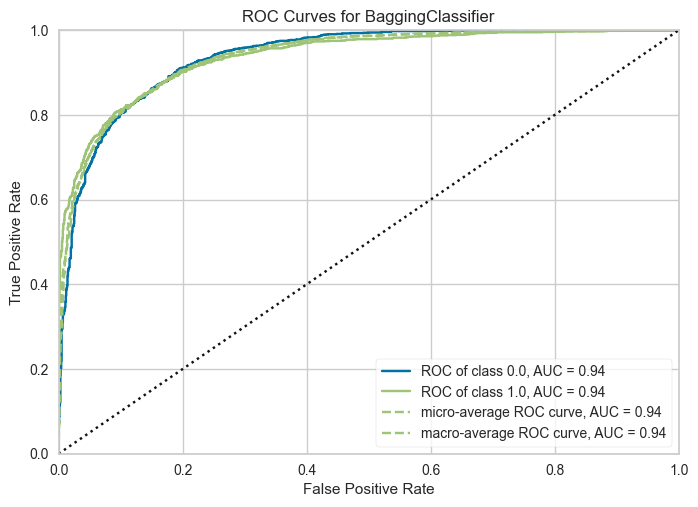

In [977]:
plot_model(lightgbm_bagged, plot='auc')

### Test the model


#### Predict on the test set

In [978]:
# predict on the test set
predict_model(lightgbm_bagged)

Type  PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  \
6878   0.0               1.0       1.297077        0.463184      0.584391   
6879   0.0               0.0       2.000000       -0.501520     -1.487777   
6880   1.0               0.0       3.000000        1.189242      1.251812   
6881   2.0               0.0       3.000000       -1.391835     -1.220312   
6882   0.0               1.0       2.000000        0.043954     -1.450672   
...    ...               ...            ...             ...           ...   
9821   0.0               0.0       0.000000       -1.378608     -1.270087   
9822   0.0               0.0       1.000000       -1.324957     -1.104358   
9823   2.0               0.0       0.000000       -1.249719      0.226270   
9824   0.0               1.0       1.000000        0.620778     -0.092215   
9825   0.0               1.0       2.000000        1.098746      0.784690   

      InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
6878              1.0             0.0           0.0               0.0   
6879              0.0             0.0           1.0               0.0   
6880              1.0             1.0           1.0               1.0   
6881              2.0             0.0           0.0               0.0   
6882              1.0             0.0           0.0               0.0   
...               ...             ...           ...               ...   
9821              2.0             0.0           0.0               0.0   
9822              2.0             0.0           0.0               0.0   
9823              2.0             0.0           0.0               0.0   
9824              1.0             1.0           0.0               1.0   
9825              1.0             0.0           0.0               0.0   

      TechSupport  ...  SeniorCitizen   Partner  Dependents  MultipleLines  \
6878          0.0  ...            1.0  1.000000         0.0        0.00000   
6879          0.0  ...            0.0  0.000000         0.0        1.00000   
6880          0.0  ...            0.0  0.000000         0.0        1.00000   
6881          0.0  ...            0.0  0.000000         0.0        0.00000   
6882          0.0  ...            1.0  1.000000         0.0        0.00000   
...           ...  ...            ...       ...         ...            ...   
9821          0.0  ...            0.0  0.467114         0.0        0.00000   
9822          0.0  ...            0.0  0.000000         1.0        0.00000   
9823          0.0  ...            0.0  1.000000         1.0        1.00000   
9824          0.0  ...            0.0  0.000000         0.0        1.00000   
9825          0.0  ...            1.0  0.000000         0.0        0.92699   

      TenureMonths  TenureYears  ExtraServicesSum  Churn  prediction_label  \
6878      0.134371     0.134371         -0.562356    1.0                 1   
6879     -1.283706    -1.283706         -0.562356    0.0                 1   
6880      0.833504     0.833504          1.061977    0.0                 0   
6881     -1.034622    -1.034622         -1.103801    0.0                 0   
6882     -1.283706    -1.283706         -1.103801    1.0                 1   
...            ...          ...               ...    ...               ...   
9821     -1.054014    -1.054014         -1.103801    1.0                 1   
9822     -0.827053    -0.827053         -1.103801    0.0                 0   
9823      1.580754     1.580754         -1.103801    0.0                 0   
9824     -0.702511    -0.702511         -0.020912    0.0                 0   
9825      0.138972     0.138972         -0.020912    1.0                 1   

      prediction_score  
6878            0.9041  
6879            0.6032  
6880            0.9412  
6881            0.9911  
6882            0.9571  
...                ...  
9821            0.9129  
9822            0.8526  
9823            0.9958  
9824            0.5649  
9825            0.9517  

[2948 rows x 23 columns]

The bagged LightGBM model performed well on the 30% of test data, with a final AUC score of 0.94 and an Accuracy score of 0.86, well above the AUC of 0.81 we set out to outperform. We'll finalize this model by training it on the whole of the seen data, and try it out in a mock real world scenario with the 5% data we extracted above that the model has yet to see, as an additional inference step.

In [979]:
final_lightgbm = finalize_model(lightgbm_bagged)

In [980]:
print(final_lightgbm)

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator',
                 BaggingClassifier(bootstrap=True, bootstrap_features=False,
                                   estimator=LGBMClassifier(boosting_type='gbdt',
                                                            class_weight=None,
                                                            colsample_bytree=1.0,
                                                            importance_type='split',
                                                            learning_rate=0.1,
                                                            max_depth=-1,
                                                            min_child_samples=20,
                                                            min_child_weight=0.001,
                                                            min_split_gain=0.0,
                                                            n_estimators=100,
   

In [981]:
# Merge target back into unseen dataframe to test final model
unseen_data = pd.merge(features_ord_unseen, target_ord_unseen, how='left', left_index=True, right_index=True)
unseen_data.head(10)

Type  PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  \
3276   2.0               1.0            2.0        1.042946      1.100300   
1620   0.0               1.0            0.0        0.286388     -0.624569   
4598   2.0               0.0            3.0       -1.237180     -1.010565   
5434   0.0               0.0            2.0       -0.773213     -0.150449   
2757   2.0               0.0            0.0        1.216412      0.496312   
6864   2.0               0.0            1.0       -1.391835     -0.169517   
5770   1.0               1.0            2.0        1.074296      0.842111   
612    1.0               1.0            1.0        1.630220      1.142043   
3328   0.0               1.0            2.0        1.496464      1.036397   
656    1.0               0.0            0.0        0.399244      0.816858   

      InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
3276              1.0             0.0           1.0               0.0   
1620              1.0             0.0           0.0               1.0   
4598              2.0             0.0           0.0               0.0   
5434              0.0             0.0           0.0               0.0   
2757              1.0             0.0           0.0               1.0   
6864              2.0             0.0           0.0               0.0   
5770              1.0             1.0           0.0               1.0   
612               1.0             1.0           1.0               1.0   
3328              1.0             0.0           1.0               1.0   
656               0.0             1.0           1.0               1.0   

      TechSupport  ...  StreamingMovies  gender  SeniorCitizen  Partner  \
3276          0.0  ...              1.0     1.0            0.0      1.0   
1620          0.0  ...              0.0     0.0            0.0      1.0   
4598          0.0  ...              0.0     0.0            0.0      1.0   
5434          0.0  ...              0.0     1.0            0.0      0.0   
2757          1.0  ...              1.0     1.0            0.0      0.0   
6864          0.0  ...              0.0     0.0            0.0      1.0   
5770          1.0  ...              0.0     0.0            0.0      0.0   
612           0.0  ...              1.0     0.0            1.0      0.0   
3328          0.0  ...              1.0     0.0            0.0      0.0   
656           0.0  ...              1.0     1.0            0.0      1.0   

      Dependents  MultipleLines  TenureMonths  TenureYears  ExtraServicesSum  \
3276         0.0            0.0      0.667448     0.667448          0.520532   
1620         0.0            0.0     -0.951594    -0.951594         -0.562356   
4598         1.0            1.0     -0.868567    -0.868567         -1.103801   
5434         0.0            0.0     -0.245858    -0.245858         -1.103801   
2757         0.0            0.0     -0.287372    -0.287372          1.061977   
6864         0.0            0.0      1.290157     1.290157         -1.103801   
5770         0.0            0.0      0.252309     0.252309          1.061977   
612          0.0            1.0      0.459878     0.459878          1.603421   
3328         0.0            1.0      0.335337     0.335337          1.061977   
656          0.0            0.0      0.501392     0.501392          1.603421   

      Churn  
3276    0.0  
1620    1.0  
4598    0.0  
5434    0.0  
2757    0.0  
6864    0.0  
5770    1.0  
612     0.0  
3328    1.0  
656     0.0  

[10 rows x 21 columns]

In [982]:
# Experiment with final model on 5% of dataset unseen
predict_model(final_lightgbm, data=unseen_data)

Type  PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  \
0     2.0               1.0            2.0        1.042946      1.100300   
1     0.0               1.0            0.0        0.286388     -0.624569   
2     2.0               0.0            3.0       -1.237180     -1.010565   
3     0.0               0.0            2.0       -0.773213     -0.150449   
4     2.0               0.0            0.0        1.216411      0.496312   
..    ...               ...            ...             ...           ...   
347   0.0               1.0            2.0       -0.929958      0.014462   
348   2.0               1.0            0.0       -0.294616      0.974040   
349   2.0               1.0            2.0        1.876833      1.760976   
350   0.0               1.0            1.0       -0.482711      0.061874   
351   1.0               1.0            0.0        1.310459      0.902406   

     InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
0                1.0             0.0           1.0               0.0   
1                1.0             0.0           0.0               1.0   
2                2.0             0.0           0.0               0.0   
3                0.0             0.0           0.0               0.0   
4                1.0             0.0           0.0               1.0   
..               ...             ...           ...               ...   
347              0.0             0.0           0.0               1.0   
348              0.0             1.0           1.0               0.0   
349              1.0             1.0           1.0               1.0   
350              0.0             1.0           1.0               0.0   
351              1.0             1.0           1.0               1.0   

     TechSupport  ...  SeniorCitizen  Partner  Dependents  MultipleLines  \
0            0.0  ...            0.0      1.0         0.0            0.0   
1            0.0  ...            0.0      1.0         0.0            0.0   
2            0.0  ...            0.0      1.0         1.0            1.0   
3            0.0  ...            0.0      0.0         0.0            0.0   
4            1.0  ...            0.0      0.0         0.0            0.0   
..           ...  ...            ...      ...         ...            ...   
347          0.0  ...            1.0      0.0         0.0            0.0   
348          1.0  ...            0.0      0.0         0.0            0.0   
349          1.0  ...            0.0      0.0         0.0            1.0   
350          0.0  ...            0.0      1.0         1.0            0.0   
351          0.0  ...            0.0      1.0         1.0            1.0   

     TenureMonths  TenureYears  ExtraServicesSum  Churn  prediction_label  \
0        0.667448     0.667448          0.520532    0.0                 0   
1       -0.951594    -0.951594         -0.562356    1.0                 1   
2       -0.868567    -0.868567         -1.103801    0.0                 0   
3       -0.245858    -0.245858         -1.103801    0.0                 0   
4       -0.287372    -0.287372          1.061977    0.0                 0   
..            ...          ...               ...    ...               ...   
347      0.086253     0.086253         -0.020912    0.0                 1   
348      1.497726     1.497726          1.603421    0.0                 0   
349      1.580754     1.580754          2.144866    0.0                 0   
350     -0.204344    -0.204344         -0.020912    0.0                 0   
351      0.335337     0.335337          1.061977    0.0                 0   

     prediction_score  
0              0.8405  
1              0.6387  
2              0.9903  
3              0.7519  
4              0.9495  
..                ...  
347            0.5180  
348            0.9859  
349            0.9638  
350            0.8612  
351            0.8311  

[352 rows x 23 columns]

Experimenting on the finalized model with an unseen 5% of the ordinal encoded and scaled data, the model AUC & Accuracy slipped down a tad bit from the holdout test scores from 0.94 & 0.85 to 0.86 & 0.80, respectively.  While absolutely still above our AUC threshold of 0.81, this does simulate a real world outcome where a model may need further hyperparameter tuning, and/or re-fitting to achieve the same performance it achieved upon testing.  This could also be due to the variance in subsample size, being much smaller than that of the training or test sets.

### Conclusion

This deep dive into telecom operator Interconnect's customer data has offered glimpses into their patterns of behavior. Our interest in this analysis being customer loyalty and their likelyhood of churning.

We began with a general overview as well as preprocessing of the data.  Starting out with four separate data files: contract.csv, internet.csv, personal.csv, and phone.csv, we combined them into one dataframe to make it easier to work with.  After taking a look at distributions of the values of the features in the data, we handled any missing values and variation in data types. We then moved on to adding a binary target column indicating whether a customer has churned or not based on their recorded end date.

Using the information gained from our preliminary analysis, we arranged a project plan to answer two main questions:
* What are the features of most importance in predicting whether a customer will leave or not?
* What is the most accurate predictive model for this binary classification problem?

With a baseline threshold AUC score of > 0.81, in depth EDA with visualizations, as well as a host of python libraries, we have answered those questions.  Our result is a bagged Light Gradient Boosted Machine classification model capable of predicting churn with an AUC score of 0.94 and accuracy score of 0.85.


### Business insights for Interconnect

The in depth exploratory data analysis garnered many insights into which customers could potentially churn and why. The following are some of those insights, and potential action that might inhibit the churn rate:

1. __Insight:__ Customers with month-to-month contracts had a much higher churn rate than both 1 and 2 year subscribers.

    __Action:__ Incentivize longer contract commitments with potential discounts or free add-on services.




2. __Insight:__ Customers who paid by electronic check were by far the majority, but were also the most likely to churn.

    __Action:__ Incentivize customers switching to, or signing up with payment by automatic withdrawl means like credit card or bank transfer.




3. __Insight:__ Inverse correlation between the amout of extra services a customer subscribes to, and their propensity to churn. The more services subscribed, the more loyal the customer.

    __Action:__ Perhaps offering an advantage to bundling services, or a month of service free to existing customers who sign up for more services could bolster customer retension.




4. __Insight:__ The bulk of customers who churned had higher monthly bills.  Similarly, those with fiber optic internet also tended to churn at a higher rate.  Could it be that the cost of fiber optic services is too high to be competive?

    __Action:__ Consider lowering the price, or increasing available tiered options for fiber optic internet in the interest of customer retension and increased profit return over time.




These actionable insights along with the predictive classification model we've built here will help to intercept vulnerable customers before they churn, and assist in fostering customer loyalty with a potential increase in consumer base and company growth over time.



## Solution Report

__Project plan steps:__
All steps laid out in the project plan were performed as presented. No steps were skipped, however a couple were added along the way. Those were:
* Adding the TenureMonth, TenureYear, and ExtraServicesSum features to the final merged dataframe
* Adding an ordinal encoded dataset in addition to a one hot encoded dataset to model compare efficiency
* Oversampling the training data using SMOTE to enhance model training

__Difficulties Encountered:__
There were a few difficulties I encountered along the way, most having to do with setting up my repo and python environment:
* To run some of the libraries I was forced to switch my initial python version from 3.12 to 3.11 after having compatability issues
* The above then forced me to have to create a new kernel for a separate conda environment in order to excute my code as written
* Using pycaret for preprocessing was not getting me the model efficacy that I had hoped for, thus I went about preprocessing the data on my own and only used pycaret for model evaluation  and training which helped achieve better results.

__Key Steps:__
In building and evaluating this model, all the steps laid out in my project plan helped, but a few helped push it over the top:
* The visual comparisons of the features in relation to the target helped draw inferences that would have been difficult to otherwise pinpoint
* The additional features created from the existing data (TenureMonth, TenureYear, and ExtraServicesSum) assisted in adding more data to shape the model with
* The oversampling using SMOTE helped greatly in training the model
* The use of Pycaret as a quick and efficient way to evaluate many different model performaces, and assisted me greatly as I was running this project locally on my laptop

__Final Model & Quality Score:__
My final model is a bagged Light Gradient Boosted Machine model.  As for it's quality score, I had thought it would be assessed based upon it's intial test run (cell [978] above), at an AUC score of 0.94 which would have earned 6 SP. However, it appears that the model is being judged on it's performace on unseen data (cell [982] above) at an AUC score of 0.86, as I was awarded only 5 SP for the solution code. I'm still very happy to have satisfactorily completed the project and hopefully, soon, the program as well!